In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.interpolate import griddata

from cs_tool import readvar_cs
from mds import rdmds

In [2]:
# directory where the model output files are saved
odir = '/Users/hajsong/MITgcm/verification/aim.5l_cs/run/'
XC = rdmds(odir+'XC')
YC = rdmds(odir+'YC')
RC = rdmds(odir+'RC').squeeze()
hFacC = rdmds(odir+'hFacC')
[nz, ny, nx] = hFacC.shape

In [3]:
# collect the iteration number from the model output files
files = sorted(glob.glob(odir+'Ttave.*.006.*.meta'))
tidx=[]
for it in range(len(files)):
    tidx.append(int(files[it][-23:-13]))
nfiles = len(tidx)

In [4]:
Theta = np.zeros([nz, ny, nx])
cnt = 0
for i, it in enumerate(tidx):
    Ttmp = rdmds(odir+'Ttave', it)
    Theta += Ttmp
    cnt += 1
Theta = Theta/cnt

In [24]:
# interpolation onto the regular grid
lon, lat = np.meshgrid(np.arange(-178.5,178.6,2), np.arange(-80.5,80.6,2))
xc = XC.flatten()
yc = YC.flatten()
hfacc = hFacC[0].flatten()
# Tsfc = T[0].flatten()
var_2deg = griddata(np.vstack((xc, yc)).T, hfacc, (lon, lat), method='nearest')
[sy, sx] = lon.shape

<ipython-input-25-1a0c003b51c6>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lon, lat, var_2deg)


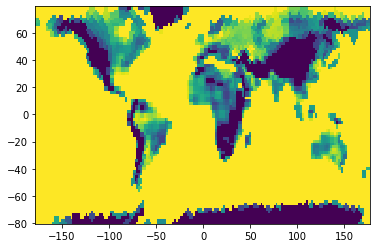

In [25]:
plt.pcolormesh(lon, lat, var_2deg)

In [26]:
var_3d = np.zeros([5, sy, sx])
for k in range(5):
    var_3d[k,:,:] = griddata(np.vstack((xc, yc)).T, Theta[k].flatten(), (lon, lat), method='nearest')


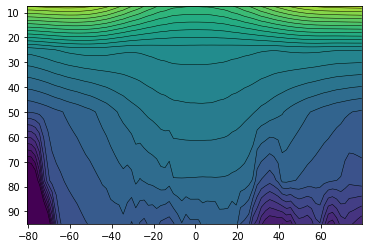

In [27]:
plt.contourf(lat[:,0],RC*1e-3,var_3d.mean(axis=2), np.arange(200,501,10), extend='both')
c = plt.contour(lat[:,0],RC*1e-3,var_3d.mean(axis=2), np.arange(200,501,10), colors='k', linewidths=0.5)
plt.gca().invert_yaxis()

### Convert from potential temperature to temperature
$$
T = \Theta\left(\frac{p}{p_{ref}}\right)^\kappa,
$$
where $\kappa = R/c_p = 0.286$ and $p_{ref} = 1e5$.

In [29]:
kappa = 0.286
# pref = 1.01325e5
pref = 1e5
T = var_3d * (np.tile(RC[:, np.newaxis, np.newaxis], (1, sy, sx))/pref)**kappa

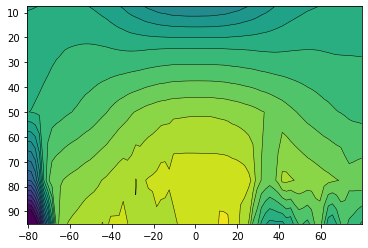

In [30]:
plt.contourf(lat[:,0],RC*1e-3,T.mean(axis=2), np.arange(100,301,10), extend='both')
c = plt.contour(lat[:,0],RC*1e-3,T.mean(axis=2), np.arange(100,301,10), colors='k', linewidths=0.5)
plt.gca().invert_yaxis()

### wind data
Because of the cubed sphere structure, the wind data needs extra steps to extract.


In [32]:
uwind = np.zeros([nz, ny, nx])
vwind = np.zeros([nz, ny, nx])
cnt = 0
for i, it in enumerate(tidx):
    utmp = rdmds(odir+'uVeltave', it)
    vtmp = rdmds(odir+'vVeltave', it)
    uwind += utmp
    vwind += vtmp
    cnt += 1
uwind = uwind/cnt
vwind = vwind/cnt

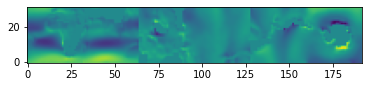

In [34]:
plt.imshow(uwind[0], origin='lower')

In [ ]:
def wind_cs(uwind, vwind):
    """
    Read the MITgcm wind files on cubed sphere grid

    [input]
    odir    :  directory for the model output
    uname   :  u-wind file name
    vname   :  v-wind file name
    it      :  iteration number

    [output]
    varall  :  combined model result
    varface :  model result on each face

    [example]
    varall, varface = readvar_cs(odir, 'T', 69120)
    """

    ndim = len(uwind.shape)

    if ndim==2:
        varall[32:32*2, :32] = data[0]
        varall[32:32*2, 32:32*2] = data[1]
        varall[32*2:32*3, 32:32*2] = data[2]
        varall[32:32*2, 32*2:32*3] = data[3,:,::-1].T
        varall[32:32*2, 32*3:32*4] = data[4,:,::-1].T
        varall[:32, 32*3:32*4] = data[5,:,::-1].T
    elif ndim==3:
        varall[:, 32:32*2, :32] = data[0]
        varall[:, 32:32*2, 32:32*2] = data[1]
        varall[:, 32*2:32*3, 32:32*2] = data[2]
        varall[:, 32:32*2, 32*2:32*3] = data[3,:,:,::-1].transpose([0,2,1])
        varall[:, 32:32*2, 32*3:32*4] = data[4,:,:,::-1].transpose([0,2,1])
        varall[:, :32, 32*3:32*4] = data[5,:,:,::-1].transpose([0,2,1])

    return varall, data


(5, 32, 192)

## sensitivity to pCO2 

In [126]:
co2dir_1 = '/Users/hajsong/MITgcm/verification/aim.5l_cs/run_co2_320/'
co2dir_2 = '/Users/hajsong/MITgcm/verification/aim.5l_cs/run_co2_420/'

In [137]:
T320 = np.zeros([nz, ny, nx])
T420 = np.zeros([nz, ny, nx])

cnt = 0
for i, it in enumerate(tidx[-1:]):
    Ttmp = rdmds(co2dir_1+'Ttave', it)
    T320 += Ttmp
    Ttmp = rdmds(co2dir_2+'Ttave', it)
    T420 += Ttmp
    cnt += 1
T320 = T320/cnt
T420 = T420/cnt

In [138]:
var_320 = np.zeros([5, sy, sx])
var_420 = np.zeros([5, sy, sx])

for k in range(5):
    var_320[k,:,:] = griddata(np.vstack((xc, yc)).T, T320[k].flatten(), (lon, lat), method='nearest')
    var_420[k,:,:] = griddata(np.vstack((xc, yc)).T, T420[k].flatten(), (lon, lat), method='nearest')



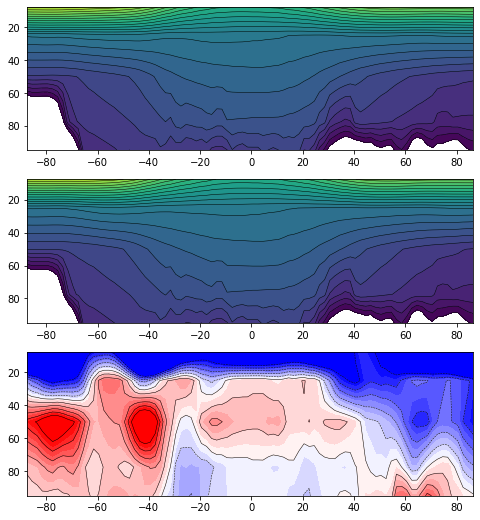

In [142]:
f, ax = plt.subplots(3,1,figsize=(8,9))

ax[0].contourf(lat[:,0],RC*1e-3,var_320.mean(axis=2), np.arange(240,501,10))
c = ax[0].contour(lat[:,0],RC*1e-3,var_320.mean(axis=2), np.arange(240,501,10), colors='k', linewidths=0.5)
ax[0].invert_yaxis()

ax[1].contourf(lat[:,0],RC*1e-3,var_420.mean(axis=2), np.arange(240,501,10))
c = ax[1].contour(lat[:,0],RC*1e-3,var_420.mean(axis=2), np.arange(240,501,10), colors='k', linewidths=0.5)
ax[1].invert_yaxis()

ax[2].contourf(lat[:,0],RC*1e-3,(var_420-var_320).mean(axis=2), np.arange(-2e0,2.1e0,2e-1), cmap='bwr', extend='both')
c = ax[2].contour(lat[:,0],RC*1e-3,(var_420-var_320).mean(axis=2), np.arange(-2e0,2.1e0,4e-1), colors='k', linewidths=0.5)
ax[2].invert_yaxis()